# X4 Image to Image Translation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py as h5
import torch as th

## Download the data from GDrive [file1](https://drive.google.com/file/d/1wBeqnl_Hjk3l5zbDHlww4V5WBUSATSuA/view?usp=drivesdk)

In [5]:
import gdown
# Google Drive file ID from the shareable link
file_id1 = "1wBeqnl_Hjk3l5zbDHlww4V5WBUSATSuA"  # Replace with actual file ID
output_path1 = "./04_image_to_image.zip"


# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path1), exist_ok=True)


# Download file from Google Drive
url = f'https://drive.google.com/uc?id={file_id1}'
gdown.download(url, output_path1, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1wBeqnl_Hjk3l5zbDHlww4V5WBUSATSuA
From (redirected): https://drive.google.com/uc?id=1wBeqnl_Hjk3l5zbDHlww4V5WBUSATSuA&confirm=t&uuid=ecfeb98d-438d-4fc6-8f7a-3c73e74d7870
To: c:\Users\braun\OneDrive\Documents\GitHub\DataScienceForElectronMicroscopy\notebooks\04_image_to_image.zip
100%|██████████| 1.29G/1.29G [00:13<00:00, 95.4MB/s]

'./04_image_to_image.zip'

In [6]:
import zipfile

# Unzip the file
with zipfile.ZipFile("04_image_to_image.zip", 'r') as zip_ref:
    zip_ref.extractall("04_image_to_image")


In [ ]:
folder = "./04_image_to_image/Simulationsdaten für Machine Learning Training/"
path_targets = path + 'projected_thickness/'
path_inputs = path + 'phase_contrast/'

## Set paths to data

In [11]:
path = '/mnt/data/datascience_miniprojects/04_ImageToImage/sim/'


## Create Dataset and Load Data

In [12]:
from PIL import Image
from glob import glob
from torch.utils.data import Dataset
import torchvision.transforms as T

class Img2ImgDataset(Dataset):
    def __init__(self, input_path, target_path):
        # Get sorted lists of file paths
        self.input_files = sorted(glob(os.path.join(input_path, '*.tif')))
        self.target_files = sorted(glob(os.path.join(target_path, '*.tif')))
        
        # Verify matching number of files
        assert len(self.input_files) == len(self.target_files), \
            "Number of input and target images must match"
            
        # Define transforms
        self.transform = T.Compose([
            T.ToTensor(),  # Convert PIL image to tensor and scale to [0,1]
        ])
        
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, idx):
        # Load images
        input_img = Image.open(self.input_files[idx])
        target_img = Image.open(self.target_files[idx])
        
        # Convert to tensors
        input_tensor = self.transform(input_img)
        target_tensor = self.transform(target_img)
        
        return input_tensor, target_tensor

# Create dataset
dataset = Img2ImgDataset(path_inputs, path_targets)

# Print dataset size
print(f"Dataset contains {len(dataset)} image pairs")

# Load first pair to verify shapes
x, y = dataset[0]
print(f"Input shape: {x.shape}")
print(f"Target shape: {y.shape}")


Dataset contains 1844 image pairs
Input shape: torch.Size([1, 1024, 1024])
Target shape: torch.Size([1, 1024, 1024])

## Create a 3x3 grid of input images

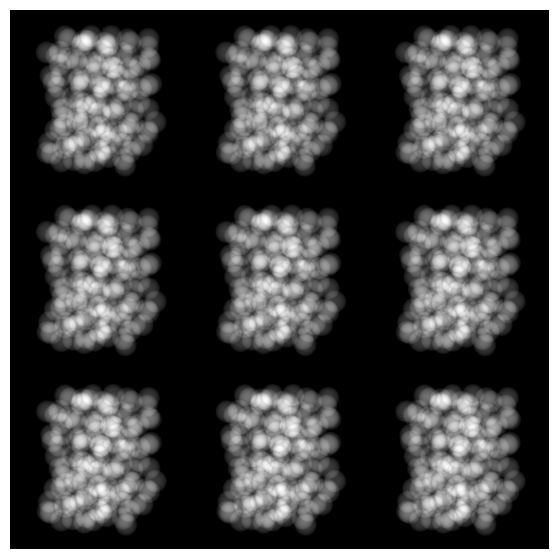

In [13]:
import torchvision

inputs = []
for i in range(9):
    x, _ = dataset[i]  # Get just the input image
    inputs.append(x)

# Use torchvision's make_grid to create a grid of images
grid = torchvision.utils.make_grid(inputs, nrow=3, padding=2)

# Convert to numpy and scale to 0-255 range for display
grid_np = (grid.squeeze().numpy() * 255).astype(np.uint8)

# Plot the grid using matplotlib
plt.figure(figsize=(7,7))
plt.imshow(grid_np.transpose(1,2,0))  # Transpose from (C,H,W) to (H,W,C) for matplotlib
plt.axis('off')
plt.show()

## Create a 3x3 grid of target images

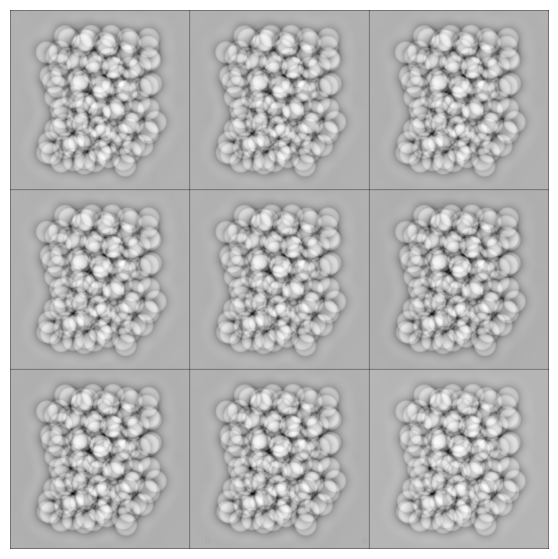

In [14]:
import torchvision

inputs = []
for i in range(9):
    _, x = dataset[i]  # Get just the input image
    inputs.append(x)

# Use torchvision's make_grid to create a grid of images
grid = torchvision.utils.make_grid(inputs, nrow=3, padding=2)

# Convert to numpy and scale to 0-255 range for display
grid_np = (grid.squeeze().numpy() * 255).astype(np.uint8)

# Plot the grid using matplotlib
plt.figure(figsize=(7,7))
plt.imshow(grid_np.transpose(1,2,0))  # Transpose from (C,H,W) to (H,W,C) for matplotlib
plt.axis('off')
plt.show()

# Create training and validation splits

Training set size: 1475
Validation set size: 369
Batch shape: torch.Size([32, 1, 1024, 1024])
Target shape: torch.Size([32, 1, 1024, 1024])

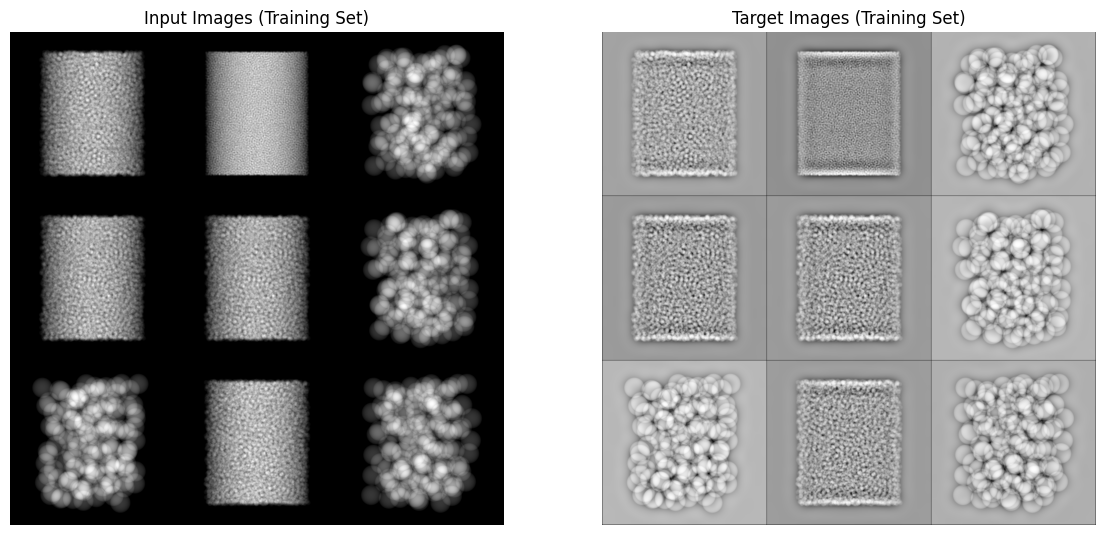

In [18]:
import torch 

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Get a random batch from training set
dataiter = iter(train_loader)
batch = next(dataiter)
input_images, target_images = batch

print(f"Batch shape: {input_images.shape}")
print(f"Target shape: {target_images.shape}")

# Display a random batch
idx = torch.randint(0, batch_size, (9,))
sample_inputs = [input_images[i] for i in idx]
sample_targets = [target_images[i] for i in idx]

# Create input grid
input_grid = torchvision.utils.make_grid(sample_inputs, nrow=3, padding=2)
input_grid_np = (input_grid.squeeze().numpy() * 255).astype(np.uint8)

# Create target grid 
target_grid = torchvision.utils.make_grid(sample_targets, nrow=3, padding=2)
target_grid_np = (target_grid.squeeze().numpy() * 255).astype(np.uint8)

# Plot side by side
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(input_grid_np.transpose(1,2,0))
plt.title('Input Images (Training Set)')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(target_grid_np.transpose(1,2,0))
plt.title('Target Images (Training Set)') 
plt.axis('off')

plt.show()



## Now we can start defining our model and training it